In [1]:
import json
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score

from utils.ltt_utils import create_x_y, run_ltt_cv, run_naive_precision_contorl


%load_ext autoreload
%autoreload 2

In [2]:
ANNOTATIONS_PATH = "/home/ubuntu/ssd/folcon/01_ovary_cuts/roi_annotation_united/all_annotations.json"
PREDICTIONS_PATH = "/home/ubuntu/ssd/folcon/04_model_predictions/efficientdet/results_depth_classif.json"
IOU_TH = .3
TARGET_PRECISION = 0.4
THS_CLASSIF = 1 - np.arange(.5, 1.5, .05)
THS_DEPTH = 1 - np.arange(.3, .8, .05)
THS_OBJ = np.arange(.3, .8, .01)
DELTA = 1e-3

In [3]:
with open(ANNOTATIONS_PATH, "r") as f:
    annotations = json.load(f)

with open(PREDICTIONS_PATH, "r") as f:
    predictions = json.load(f)


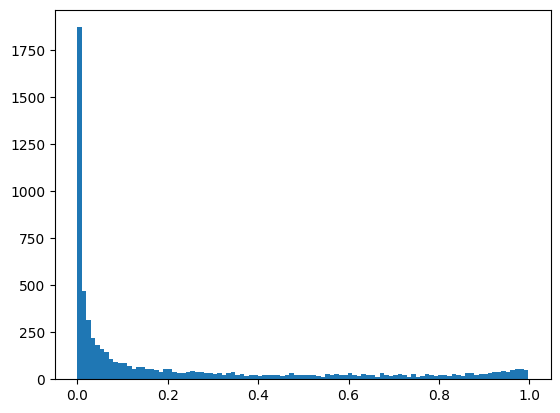

In [4]:
scores_classif = []
for slide_name in predictions:
    for roi in predictions[slide_name]:
        scores_classif.extend(predictions[slide_name][roi]["scores_classif"])
plt.hist(scores_classif, bins=100)
plt.show()

In [5]:
naive_method = run_naive_precision_contorl(
    annotations, predictions, target_precision=TARGET_PRECISION,
    iou_th=IOU_TH, ths_obj=THS_OBJ, classes="all", n_split=100
)

ltt_results_depth_fst = run_ltt_cv(
    annotations, predictions, target_precision=TARGET_PRECISION,
    iou_th=IOU_TH, ths_dict={"scores": THS_OBJ, "depths": THS_DEPTH},
    classes="all", delta=DELTA, correction="fst", n_split=100
)

ltt_results_classif_fst = run_ltt_cv(
    annotations, predictions, target_precision=TARGET_PRECISION,
    iou_th=IOU_TH, ths_dict={"scores": THS_OBJ, "scores_classif": THS_CLASSIF},
    classes="all", delta=DELTA, correction="fst", n_split=100
)

ltt_results_classical = run_ltt_cv(
    annotations, predictions, target_precision=TARGET_PRECISION,
    iou_th=IOU_TH, ths_dict={"scores": THS_OBJ},
    classes="all", delta=DELTA, correction="fst", n_split=100
)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:46<00:00,  2.13it/s]


In [6]:
def format_ltt_results(ltt_results_dict, method_name):
    n_iter = len(ltt_results_dict) // 3
    list_precisions = [list(ltt_results_dict.values())[i]["precision"] for i in range(n_iter)]
    list_recalls = [list(ltt_results_dict.values())[i]["recall"] for i in range(n_iter)]
    list_f1s = list(
        np.array(list_precisions, dtype=float) * np.array(list_recalls, dtype=float) * 2 / (np.array(list_precisions, dtype=float) + np.array(list_recalls, dtype=float))
    )
    final_dico = {
        "Metric": ["Precision"] * n_iter + ["Recall"] * n_iter + ["F1-score"] * n_iter,
        "Value": list_precisions + list_recalls + list_f1s,
        "Method": [method_name] * (n_iter * 3)
    }
    return final_dico

In [7]:
dico_ltt_depth_fst = format_ltt_results(ltt_results_depth_fst, "LTT with objectness + depth")
dico_ltt_classif_fst = format_ltt_results(ltt_results_classif_fst, "LTT with objectness + classif")
dico_ltt_classical = format_ltt_results(ltt_results_classical, "LTT objectness")
dico_ltt_naive = format_ltt_results(naive_method, "Naive method")

In [8]:
concat_dico = pd.concat([
    pd.DataFrame(dico_ltt_depth_fst),
    pd.DataFrame(dico_ltt_classif_fst),
    pd.DataFrame(dico_ltt_classical).dropna(),
    pd.DataFrame(dico_ltt_naive)
])

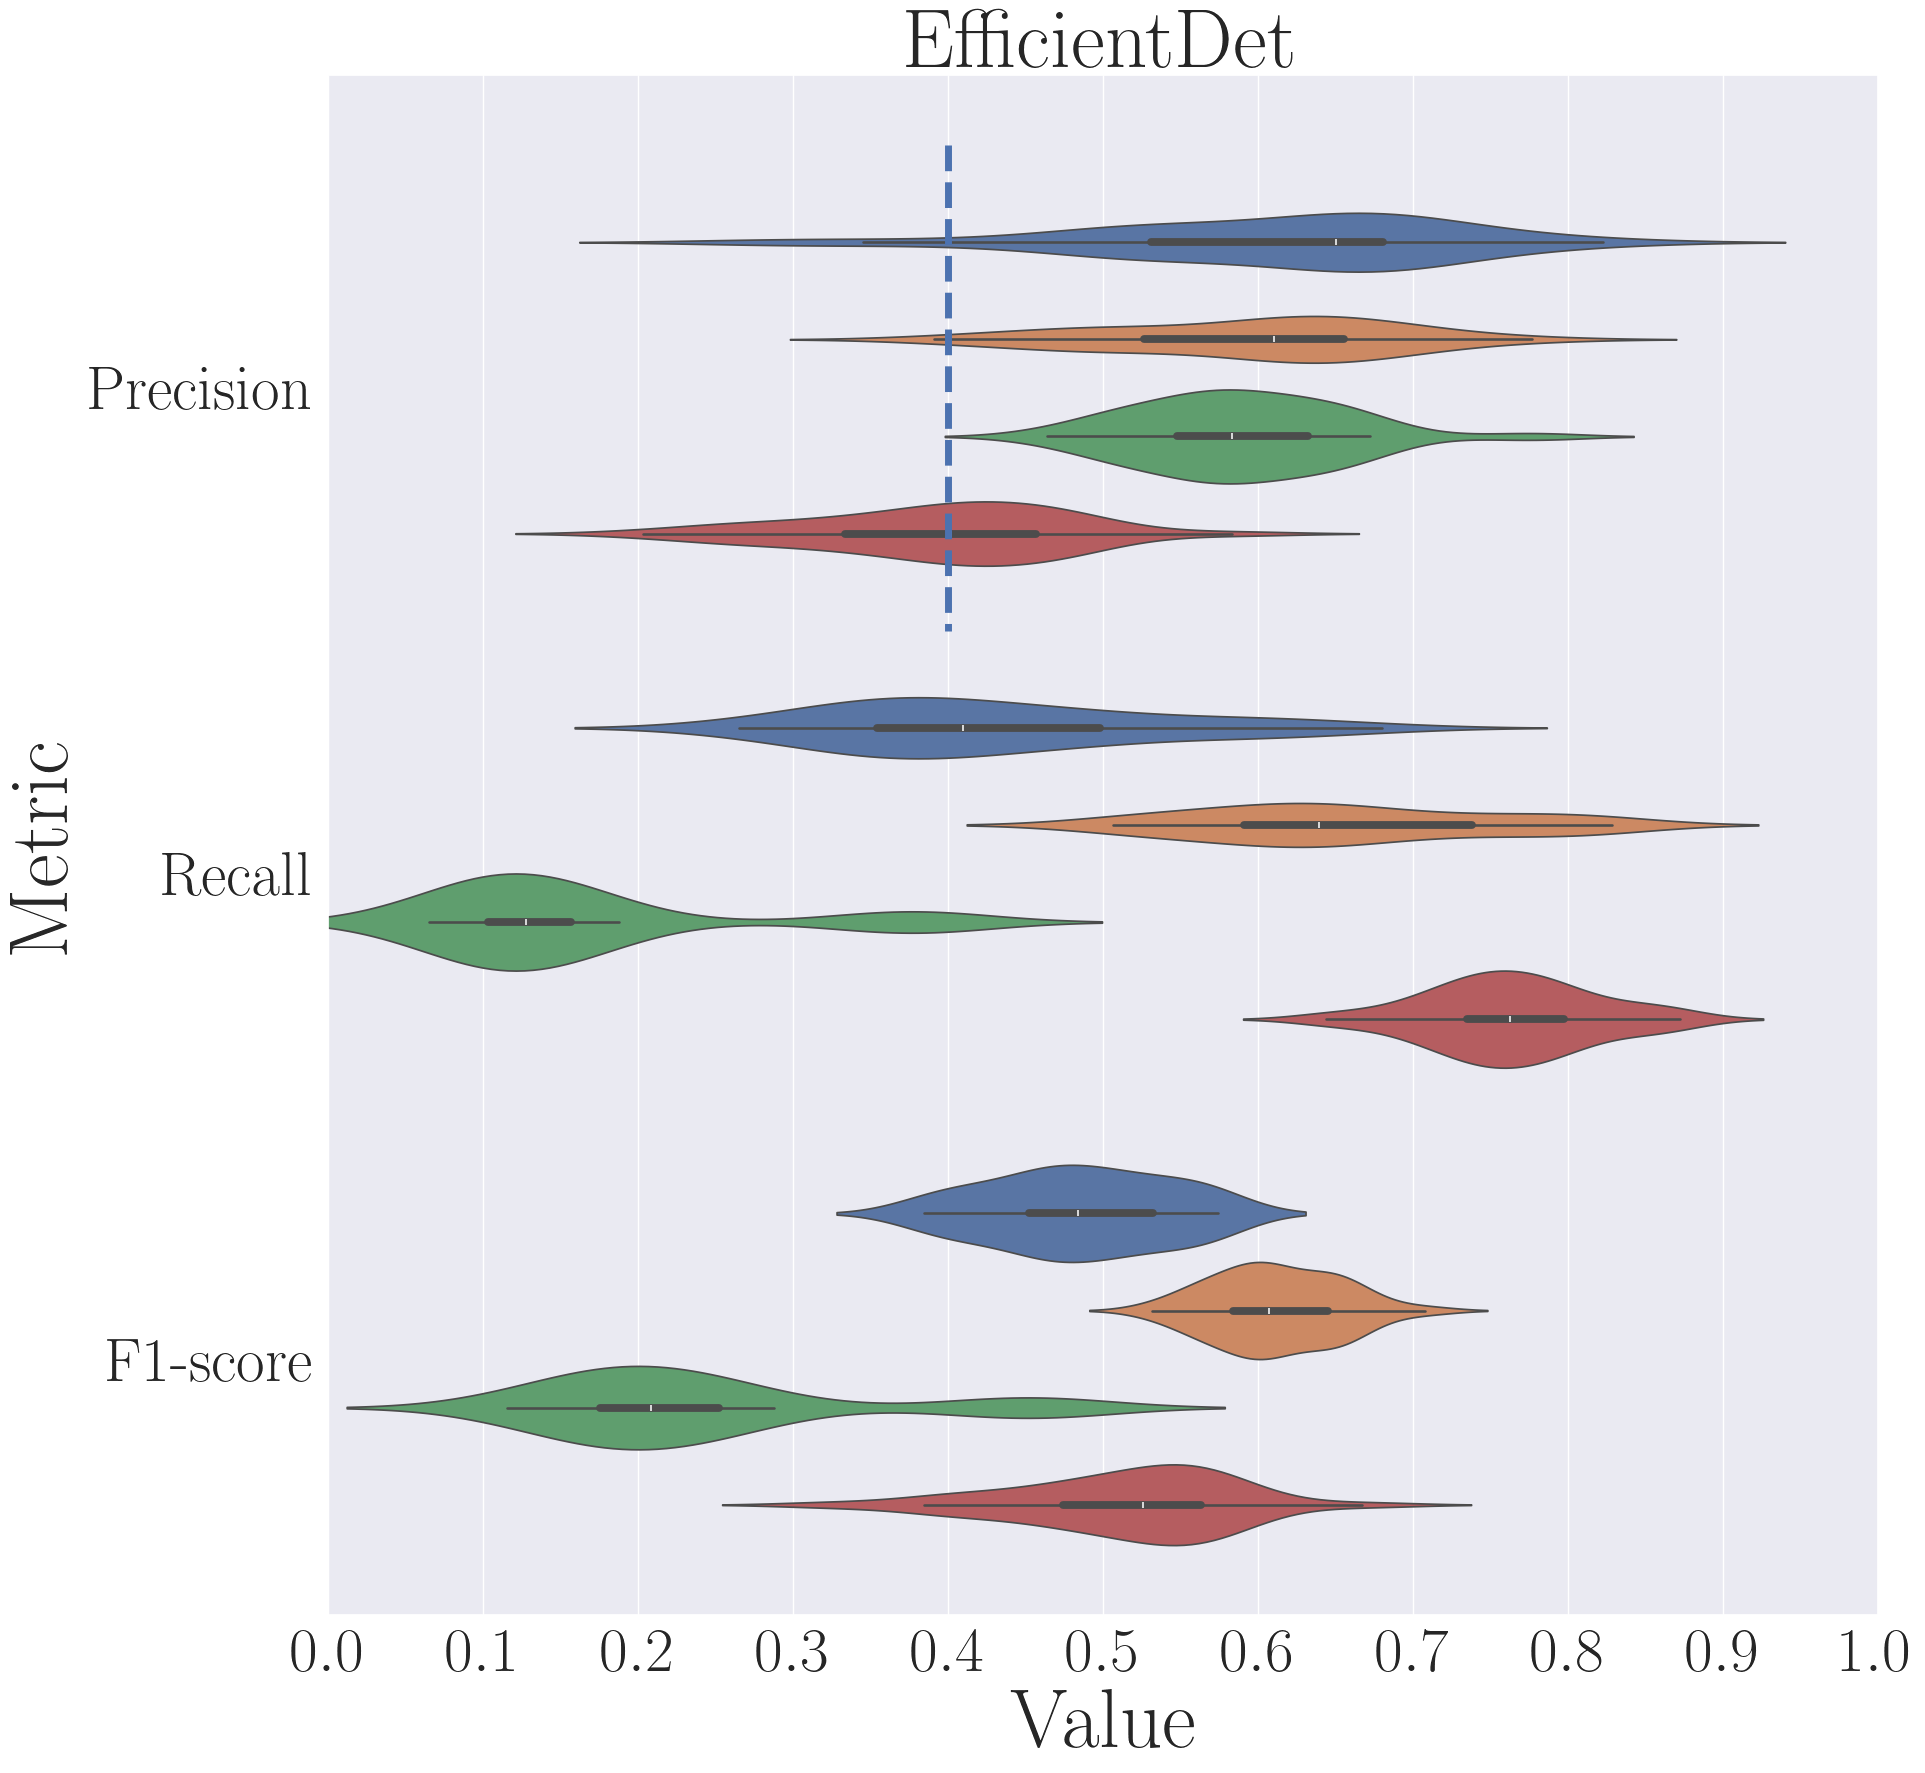

In [15]:
#plot with latex font
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
# sns.set(font_scale=10)

ax = plt.figure(figsize=(20, 20))

plot = sns.violinplot(
    data=concat_dico,  x="Value", y="Metric",
    hue="Method", split=False, orient="h",
    legend=False
)
plot.set_xlabel("Value", fontsize=60)
plot.set_ylabel("Metric", fontsize=60)
plot.set_xlim(0, 1)
plt.vlines(TARGET_PRECISION, -0.5, .5, linestyles="dashed", label="Target precision", linewidth=5)
# put legend on the side, bottom right
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=40)
plt.xticks(ticks=np.arange(0, 1.1, .1), fontsize=45)
plt.yticks(fontsize=45)
plt.title("EfficientDet", fontsize=60)
plt.savefig("ltt_results_effdet.pdf", bbox_inches='tight')
plt.show()


In [11]:
dico_mean_ths = {
    "Naive method": {
        "objectness": np.nanmean([v["best_th_obj"] for v in naive_method.values()]),
        "depth": np.nan,
        "classification": np.nan
    },
    "LTT objectness": {
        "objectness": np.nanmean([v["best_th_scores"] for v in ltt_results_classical.values()]),
        "depth": np.nan,
        "classification": np.nan
    },
    "LTT objectness + depth": {
        "objectness": np.nanmean([v["best_th_scores"] for v in ltt_results_depth_fst.values()]),
        "depth": np.nanmean([v["best_th_depths"] for v in ltt_results_depth_fst.values()]),
        "classification": np.nan
    },
    "LTT objectness + classif": {
        "objectness": np.nanmean([v["best_th_scores"] for v in ltt_results_classif_fst.values()]),
        "depth": np.nan,
        "classification": np.nanmean([v["best_th_scores_classif"] for v in ltt_results_classif_fst.values()])
    },
}


In [12]:
pd.DataFrame(dico_mean_ths).T.to_latex()

'\\begin{tabular}{lrrr}\n\\toprule\n & objectness & depth & classification \\\\\n\\midrule\nNaive method & 0.568283 & NaN & NaN \\\\\nLTT objectness & 0.700000 & NaN & NaN \\\\\nLTT objectness + depth & 0.640808 & 0.519192 & NaN \\\\\nLTT objectness + classif & 0.536263 & NaN & 0.217172 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [13]:
pd.DataFrame(dico_mean_ths).T.to_latex("ltt_results_effdet.tex", float_format="%.3f")